# Emergency Room Data Analysis
by Stephen Brock

## Purpose

The purpose of this notebook is to analyze (simulated) emergency department (ED) data, to develop actionable insights for ED employees.


Key Insights I explore are:
- Length of stay (time from patient arrival to patient leaving the ED)
- Time to seeing a physician (time from patient arrival to physician initial assessment)
- counts and proportions of presenting complaints
- counts and proportions of Triage scores (CTAS)
- distribution of number of encounters seen per day

Key Questions I answer are:
1. Are more encounters seen on weekdays than on weekends?
2. At which hour of the day do we see the most encounters?






## Table of Contents
1. [Introduction](#Introduction)
2. [Data Investigation](#Data-Investigation)
3. [Data Inquiries](#Data-Inquiries)
    1. [Insights 1](#Insights-1)
4. [Encounters Per Day Analysis](#Encounters-Per-Day-Analysis)
    1. [Insights 2](#Insights-2)
5. [Volume Analysis](#Volume-Analysis)
    1. [Insights 3](#Insights-3)
6. [Hypothesis Test](#Hypothesis-Test)
    1. [Insights 4](#Insights-4)
7. [Permutation Distribution Analysis](#Permutation-Distribution-Analysis)
    1. [Insights 5](#Insights-5)
8. [Census Analysis](#Census-Analysis)
    1. [Insights 6](#Insights-6)
9. [Key Takeaways](#Key-Takeaways)




## Data

This is a simulated dataset containing all emergency department encounters between January 1st 2019 and January 1st 2020. The chief of the ED explains that very few people have looked at the data so far, but the following variables are contained in the data

### Variable Information

- **ENCOUNTER_NUM**: a unique ID given to a patient arriving at the ED
- **CTAS_CD**: The triage code. The Canadian Triage and Acuity Score measures the severity of a patient’s condition. It ranges -from 1-5 with 1 being most severe and 5 being least severe.
- **CTAS_DESCR**: The description of the CTAS score value:
    - RESUSCITATION
    - EMERGENCY
    - URGENT
    - SEMI-URGENT
    - NON URGENT
- **ed_start_time**: The date and time of the patient arrival to the ED
- **ed_end_time**: The date and time that a patient leaves the ED
- **ed_pia_time**: The date and time that a patient first sees a physician (pia = physician initial assessment)
- **adm_start_time**: The date and time that a patient is admitted to the hospital
- **admitted**: an indicator for whether or not a patient is admitted to the hospital.
- **los**: A calculated variable measuring the time of a patient arrival to departure in hours
- **presenting_complaint**: The reason for the admission.

## Data Investigation
[back to top](#Emergency-Room-Data-Analysis)




#### Import libraries



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import scipy
import datetime as D
import sklearn.model_selection
np.random.seed(23)

sns.set_style('whitegrid')

In [2]:
data = pd.read_csv('raw_ed_data.csv')

In [3]:
# look at the head of the data
data.head()

,ENCOUNTER_NUM,CTAS_CD,CTAS_DESCR,ed_start_time,ed_end_time,ed_pia_time,adm_start_time,admitted,los,presenting_complaint
0,1,2.0,EMERGENCY,2019-01-01T06:06:00Z,2019-01-01T09:56:00Z,2019-01-01T06:22:00Z,NaN,0,3.833333,Sore Throat
1,2,3.0,URGENT,2019-01-01T06:11:00Z,2019-01-01T06:43:00Z,2019-01-01T06:40:00Z,NaN,0,0.533333,Lower extremity injury
2,3,3.0,URGENT,2019-01-01T06:21:00Z,2019-01-01T11:27:00Z,2019-01-01T06:42:00Z,NaN,0,5.100000,Back pain
3,4,2.0,EMERGENCY,2019-01-01T06:36:00Z,2019-01-01T11:48:00Z,2019-01-01T06:45:00Z,NaN,0,5.200000,Sore Throat
4,5,1.0,RESUSCITATION,2019-01-01T06:37:00Z,2019-01-01T08:27:00Z,2019-01-01T06:53:00Z,2019-01-01T07:56:00Z,1,1.833333,Abdominal pain


In [4]:
data.describe()

,ENCOUNTER_NUM,CTAS_CD,admitted,los
count,80464.000000,79258.000000,80464.000000,79278.000000
mean,40800.491711,2.816422,0.144363,5.505538
std,23420.568818,0.876367,0.351459,5.653631
min,1.000000,1.000000,0.000000,-15.000000
25%,21001.750000,2.000000,0.000000,2.400000
50%,41117.500000,3.000000,0.000000,3.950000
75%,61017.250000,3.000000,0.000000,6.650000
max,81133.000000,5.000000,1.000000,24.000000


In [5]:
# sort times based on length to see if there is any funny business
# also see how long it takes to extract all the times
ed_start = data['ed_start_time'].values
ed_end = data['ed_end_time'].values
ed_pia = data['ed_pia_time'].values
adm_start = data['adm_start_time'].values

In [6]:
# get unique encounter_num's
ids, id_counts = np.unique(data['ENCOUNTER_NUM'],return_counts=True)
print(len(ids[id_counts==2]))
ids_filter = ids[id_counts==2]

216


In [7]:
# Find all double entries
data[data['ENCOUNTER_NUM'].isin(ids_filter)].head()

,ENCOUNTER_NUM,CTAS_CD,CTAS_DESCR,ed_start_time,ed_end_time,ed_pia_time,adm_start_time,admitted,los,presenting_complaint
43048,43934,2.0,EMERGENCY,2019-07-18T00:01:00Z,2019-07-18T08:14:00Z,2019-07-18T01:10:00Z,2019-07-18T06:36:00Z,1,8.216667,Chest pain
43049,43934,2.0,EMERGENCY,2019-07-18T00:01:00Z,2019-07-18T08:14:00Z,2019-07-18T01:10:00Z,2019-07-18T06:36:00Z,1,8.216667,Chest pain
43050,43935,2.0,EMERGENCY,2019-07-18T00:07:00Z,2019-07-18T05:55:00Z,2019-07-18T03:36:00Z,NaN,0,5.800000,Loss of hearing
43051,43935,2.0,EMERGENCY,2019-07-18T00:07:00Z,2019-07-18T05:55:00Z,2019-07-18T03:36:00Z,NaN,0,5.800000,Loss of hearing
43052,43936,4.0,SEMI-URGENT,2019-07-18T00:10:00Z,2019-07-18T06:38:08Z,2019-07-18T03:13:24Z,NaN,0,6.468889,Abdominal pain


In [8]:
dt_obj = datetime.datetime.strptime(ed_start[1], "%Y-%m-%dT%H:%M:%SZ")
print(dt_obj)
print(dt_obj.date())
print(dt_obj.time())

2019-01-01 06:11:00
2019-01-01
06:11:00


In [9]:
# find all NAs, then extract all hour, days, and hours

In [10]:
#print(np.unique(np.array(ed_start, dtype=np.str)))
print('number of ed_start NAs:',np.sum(np.array(ed_start, dtype=np.str) == 'nan'))  # 793
print('number of ed_end NAs:',np.sum(np.array(ed_end, dtype=np.str) == 'nan'))  # 396
print('number of pia NAs:',np.sum(np.array(ed_pia, dtype=np.str) == 'nan'))  # 0
print('number of admission start:',np.sum(np.array(adm_start, dtype=np.str) == 'nan'))  # 68849
# investigate the nan's

number of ed_start NAs: 793
number of ed_end NAs: 396
number of pia NAs: 0
number of admission start: 68849


In [11]:
# What do the cases look like when ed start time is nan?
data[np.array(ed_start,dtype=np.str) == 'nan'].head()

,ENCOUNTER_NUM,CTAS_CD,CTAS_DESCR,ed_start_time,ed_end_time,ed_pia_time,adm_start_time,admitted,los,presenting_complaint
68,69,3.0,URGENT,NaN,2019-01-02T04:13:00Z,2019-01-01T15:36:00Z,NaN,0,NaN,Back pain
111,112,2.0,EMERGENCY,NaN,2019-01-01T20:33:00Z,2019-01-01T19:50:00Z,NaN,0,NaN,Burn
153,154,1.0,RESUSCITATION,NaN,2019-01-02T02:20:00Z,2019-01-01T23:50:00Z,2019-01-02T01:14:00Z,1,NaN,Bizarre behaviour
368,369,3.0,URGENT,NaN,2019-01-03T06:02:00Z,2019-01-02T23:59:00Z,NaN,0,NaN,Lower extremity injury
427,428,2.0,EMERGENCY,NaN,2019-01-03T13:21:00Z,2019-01-03T07:31:00Z,NaN,0,NaN,Confusion


In [12]:
# check to see if there are patients who were not admitted but have adm_start time

In [13]:
# alternative way to count NAs using Pandas

data.isna().sum()

ENCOUNTER_NUM               0
CTAS_CD                  1206
CTAS_DESCR               1206
ed_start_time             793
ed_end_time               396
ed_pia_time                 0
adm_start_time          68849
admitted                    0
los                      1186
presenting_complaint        0
dtype: int64

In [14]:
# look at distribution of days, hours, months
def get_hour(t):
    return t[11:13]

def get_day(t):
    return t[8:10]

def get_month(t):
    return t[5:7]

def get_year(t):
    return t[:4]

def get_day_week(t):
    return datetime.datetime.strptime(t, "%Y-%m-%dT%H:%M:%SZ").weekday()
    
hours = [get_hour(x) for x in ed_start if str(x) != 'nan']
days = [get_day(x) for x in ed_start if str(x) != 'nan']
months = [get_month(x) for x in ed_start if str(x) != 'nan']
day_week = [get_day_week(x) for x in ed_start if str(x) != 'nan']
years = [get_year(x) for x in ed_start if str(x) != 'nan']

In [15]:
# Check unique values of year, month, and day
print(np.unique(years, return_counts=True))
print(np.unique(days, return_counts=True))
print(np.unique(months, return_counts=True))
print(np.unique(hours, return_counts=True))

(array(['2019', '2020'], dtype='<U4'), array([79636,    35]))
(array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31'], dtype='<U2'), array([2497, 2405, 2467, 2504, 2728, 2727, 2678, 2536, 2718, 2600, 2672,
       2740, 2684, 2659, 2561, 2588, 2685, 2825, 2590, 2681, 2618, 2553,
       2653, 2555, 2575, 2647, 2632, 2542, 2419, 2341, 1591]))
(array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12'], dtype='<U2'), array([6650, 6031, 6906, 5509, 7025, 6668, 7209, 7062, 6659, 6804, 6621,
       6527]))
(array(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
       '22', '23'], dtype='<U2'), array([4171, 3668, 3734, 3352, 2957, 2656, 2343, 1924, 1612, 1615, 1336,
       1222, 1423, 2000, 2657, 3576, 4879, 5240, 5177, 5155, 5

No strange values for year, month, day, and hour

#### Set default matplotlib settings

In [16]:

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [17]:
day_bar, count_bar = np.unique(day_week, return_counts=True)
# import calendar
# calendar.day_name[4]

# create columns to check time fields - one column should be less than the other
# test comparison of dates
datetime.datetime.strptime(ed_start[0], "%Y-%m-%dT%H:%M:%SZ") < datetime.datetime.strptime(ed_start[1], "%Y-%m-%dT%H:%M:%SZ")

True

#### Find illogical times

In [18]:
# create columns to check time fields - one column should be less than the other

D.datetime.strptime(ed_start[0], "%Y-%m-%dT%H:%M:%SZ") < datetime.datetime.strptime(ed_start[1], "%Y-%m-%dT%H:%M:%SZ")
ed_start_greater_than_end = [D.datetime.strptime(ed_start[i], "%Y-%m-%dT%H:%M:%SZ") > \
                          datetime.datetime.strptime(ed_end[i], "%Y-%m-%dT%H:%M:%SZ") \
                          for i in range(len(ed_start)) if (str(ed_start[i]) != 'nan') and (str(ed_end[i]) != 'nan')]
ed_start_greater_than_pia = [D.datetime.strptime(ed_start[i], "%Y-%m-%dT%H:%M:%SZ") > \
                          datetime.datetime.strptime(ed_pia[i], "%Y-%m-%dT%H:%M:%SZ") \
                          for i in range(len(ed_start)) if (str(ed_start[i]) != 'nan') and (str(ed_pia[i]) != 'nan')]
ed_start_greater_than_adm = [D.datetime.strptime(ed_start[i], "%Y-%m-%dT%H:%M:%SZ") > \
                          datetime.datetime.strptime(adm_start[i], "%Y-%m-%dT%H:%M:%SZ") \
                          for i in range(len(ed_start)) if (str(ed_start[i]) != 'nan') and (str(adm_start[i]) != 'nan')]


In [19]:
print('number of ed start times > end times:',np.sum(ed_start_greater_than_end))
print('number of ed start times > pia start times:',np.sum(ed_start_greater_than_pia))
print('number of ed start times > adm start times:',np.sum(ed_start_greater_than_adm))

number of ed start times > end times: 1591
number of ed start times > pia start times: 16
number of ed start times > adm start times: 7


#### See if patients were admitted without start time

There was one patient who was admitted without an admitted start time, encounter_num 14904. Maybe the nurse was in a rush.

In [20]:
# check admitted without adm start time
for index, row in data.iterrows():
    if row['admitted'] == 1 and pd.isna(row['adm_start_time']):
        print(row)

ENCOUNTER_NUM                          14904
CTAS_CD                                    2
CTAS_DESCR                         EMERGENCY
ed_start_time           2019-03-10T03:11:00Z
ed_end_time             2019-03-10T21:18:00Z
ed_pia_time             2019-03-10T04:17:00Z
adm_start_time                           NaN
admitted                                   1
los                                  18.1167
presenting_complaint          Hallucinations
Name: 14903, dtype: object


## Emergency Department Start time


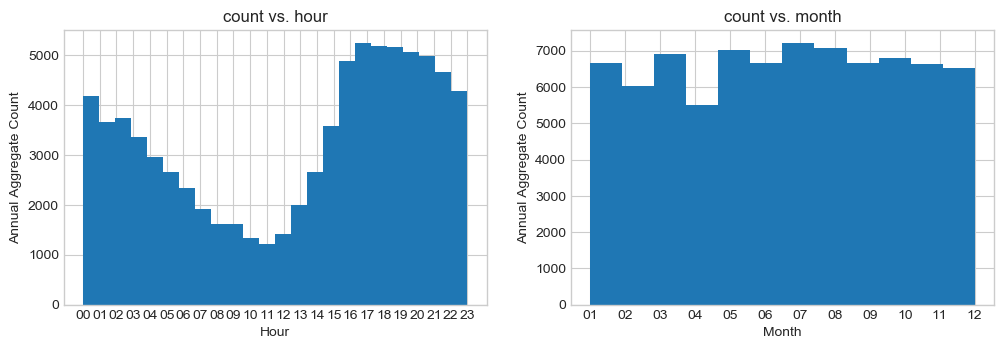

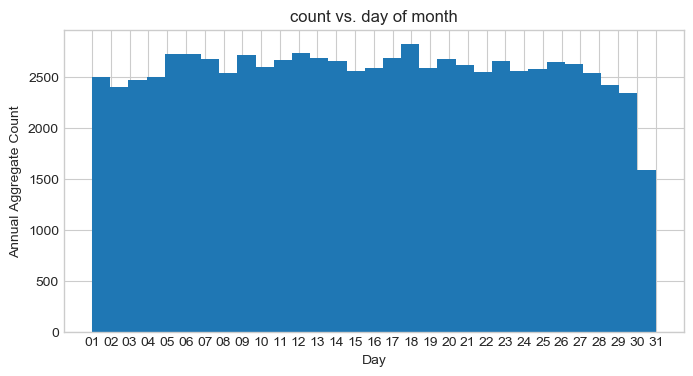

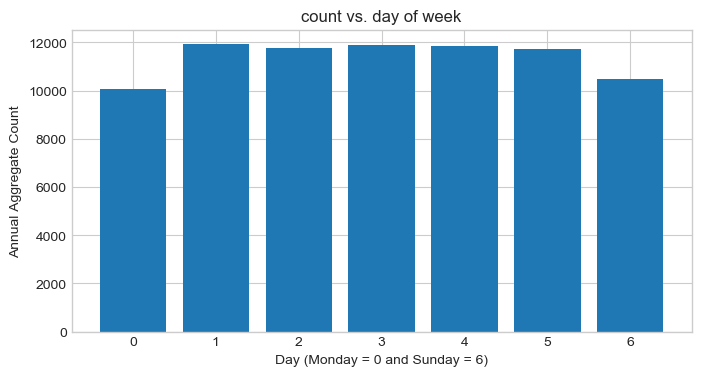

In [21]:
plt.figure(1)
plt.subplot(2,2,1)
plt.title("count vs. hour")
plt.ylabel('Annual Aggregate Count')
plt.xlabel('Hour')
plt.hist(hours, bins=24)
plt.subplot(2,2,2)
plt.title("count vs. month")
plt.ylabel('Annual Aggregate Count')
plt.xlabel('Month')
plt.hist(months, bins=12)
plt.show()
plt.figure(2)
plt.figure(figsize=(8,4))
plt.title("count vs. day of month")
plt.ylabel('Annual Aggregate Count')
plt.xlabel('Day')
plt.hist(days, bins=31)
plt.show()
plt.figure(4)
plt.figure(figsize=(8,4))
plt.title("count vs. day of week")
plt.ylabel('Annual Aggregate Count')
plt.xlabel('Day (Monday = 0 and Sunday = 6)')
plt.bar(day_bar, count_bar)
plt.show()

### Notes on hour data:
It seems that the busiest time is around the late afternoon 5pm.

### Notes on month data:
It seems that the busiest months are July and August by a bit. February and April are much lower than the rest. February could be due to the fact that it is a shorter month.

### Notes on day data:
It seems that the days of the month are pretty similar. It makes sense that the 31 day has much less as only 7 of the months have 31 days. More people visit on weekdays vs weekends on average. Sunday and Monday seem to have the fewest number of complaints.

#### Length of stay 
(time from patient arrival to patient leaving the ED)

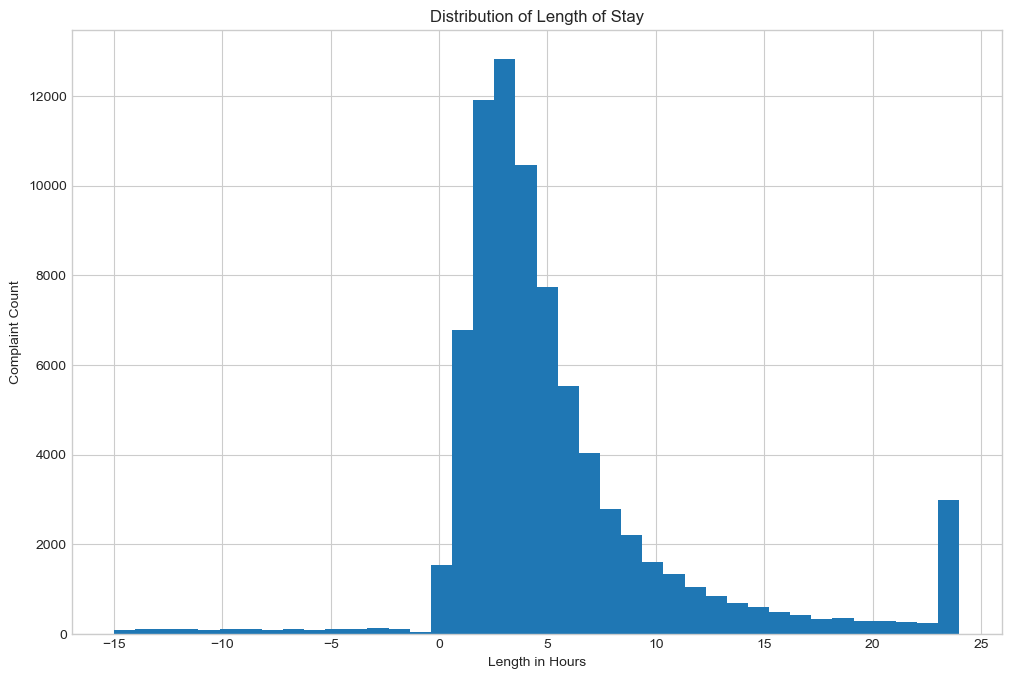

In [22]:
# Length of stay
los = [v for v in data['los'].values if not pd.isnull(v)]
plt.hist(los, bins=40)
plt.title('Distribution of Length of Stay')
plt.xlabel('Length in Hours')
plt.ylabel('Complaint Count')
plt.show()


- The majority of people are in and out within 5 hours, which is good.
- Why are there so many with a length of stay of 24 hours? Is that the maximum possible time to have?

In [23]:
# investigate length of stay patients >23 hours
subset_los = data[data['los'] > 23]
subset_los.head()

,ENCOUNTER_NUM,CTAS_CD,CTAS_DESCR,ed_start_time,ed_end_time,ed_pia_time,adm_start_time,admitted,los,presenting_complaint
139,140,2.0,EMERGENCY,2019-01-01T22:19:00Z,2019-01-03T22:03:00Z,2019-01-01T22:49:00Z,2019-01-02T01:32:00Z,1,24.0,Confusion
280,281,2.0,EMERGENCY,2019-01-02T17:12:00Z,2019-01-03T21:02:00Z,2019-01-02T19:01:00Z,2019-01-02T23:01:00Z,1,24.0,Traumatic injury
339,340,2.0,EMERGENCY,2019-01-02T21:00:00Z,2019-01-06T05:33:00Z,2099-01-01T00:00:00Z,2019-01-03T01:44:00Z,1,24.0,Traumatic injury
370,371,3.0,URGENT,2019-01-02T23:13:00Z,2019-01-04T21:06:00Z,2019-01-03T02:40:00Z,2019-01-03T06:28:00Z,1,24.0,Traumatic injury
391,392,1.0,RESUSCITATION,2019-01-03T01:00:00Z,2019-01-04T19:54:00Z,2019-01-03T01:29:00Z,2019-01-03T04:43:00Z,1,24.0,Traumatic injury


#### Notes
- We see that the max los is 24 hours.
- We can fix this by creating los_fix that has no cap of 24 (we will use the old los if ed_start or ed_end is missing)

In [24]:
def fix_los(data):
    start = data['ed_start_time'].values
    end = data['ed_end_time'].values
    los = data['los'].values
    n = len(start)
    los_fix = list()
    for i in range(n):
        si = start[i] 
        ei = end[i]
        old = los[i]
        if not pd.isnull(si) and not pd.isnull(ei):
            a = datetime.datetime.strptime(si, "%Y-%m-%dT%H:%M:%SZ")
            b = datetime.datetime.strptime(ei, "%Y-%m-%dT%H:%M:%SZ")
            length = b-a
            length = length.total_seconds()/3600
            los_fix.append(length)
        else:
            los_fix.append(old)
    
    data['los_fix'] = np.array(los_fix)
    return data

data = fix_los(data)
    
    

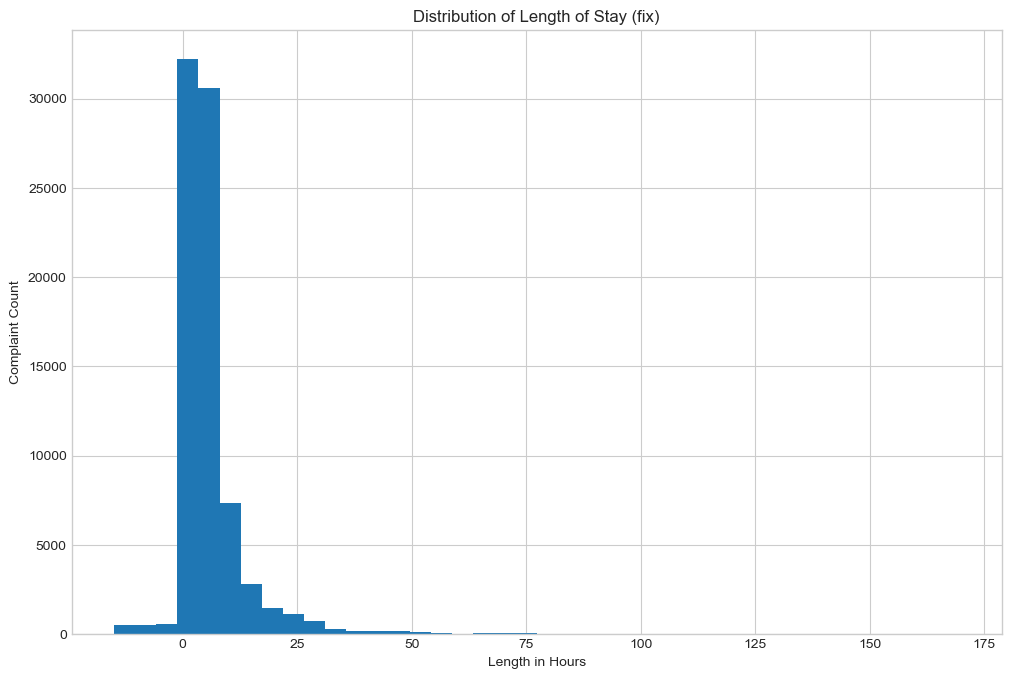

In [25]:
los_updated = [v for v in data['los_fix'].values if not pd.isnull(v)]
plt.hist(los_updated, bins=40)
plt.title('Distribution of Length of Stay (fix)')
plt.xlabel('Length in Hours')
plt.ylabel('Complaint Count')
plt.show()


#### Time to seeing a physician
(time from patient arrival to physician initial assessment)

Note: proportion of cases with 0 <= length <=36 hours: 0.98


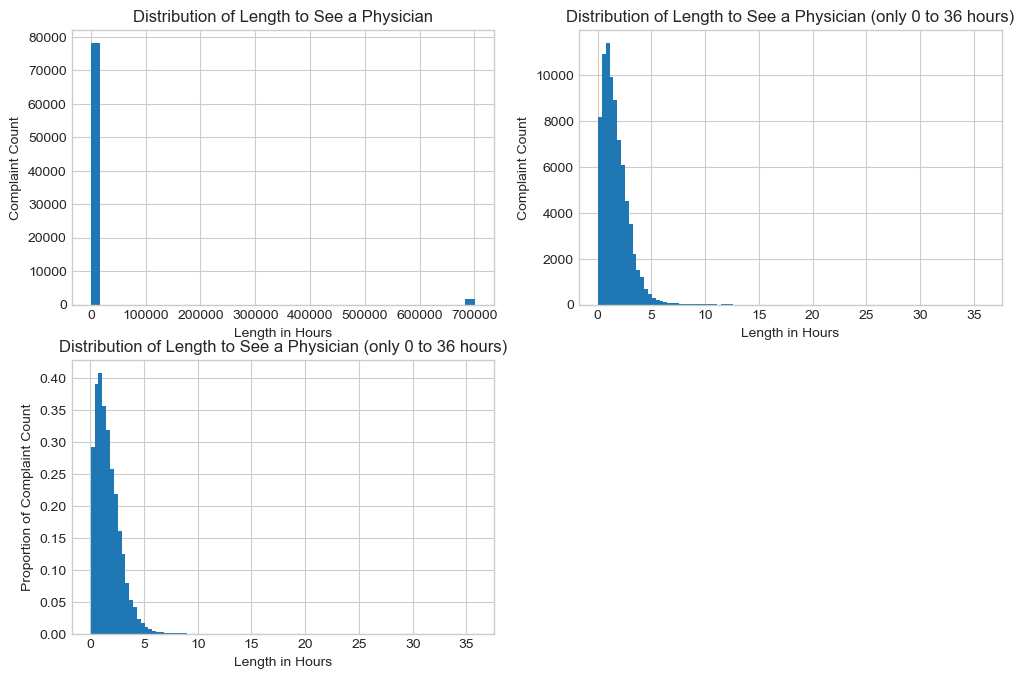

In [26]:
# time to seeing a physician
def get_time_to_pia(data):
    subset = data[~data['ed_start_time'].isnull() & ~data['ed_pia_time'].isnull()]
    a = np.array([datetime.datetime.strptime(v, "%Y-%m-%dT%H:%M:%SZ") for v in subset['ed_pia_time'].values])
    b = np.array([datetime.datetime.strptime(v, "%Y-%m-%dT%H:%M:%SZ") for v in subset['ed_start_time'].values])
    result = a - b
    result = np.array([r.total_seconds()/3600 for r in result])
    return result

times_to_pia = get_time_to_pia(data)
plt.subplot(2,2,1)
plt.hist(times_to_pia, bins=40)
plt.title('Distribution of Length to See a Physician')
plt.xlabel('Length in Hours')
plt.ylabel('Complaint Count')


# remove outliers
ids = times_to_pia <= 36 
ids_2 = times_to_pia >= 0
times_to_pia_fix = times_to_pia[ids & ids_2]
print('Note: proportion of cases with 0 <= length <=36 hours:', np.round(len(times_to_pia_fix)/len(times_to_pia),3))
plt.subplot(2,2,2)
plt.hist(times_to_pia_fix, bins=100)
plt.title('Distribution of Length to See a Physician (only 0 to 36 hours)')
plt.xlabel('Length in Hours')
plt.ylabel('Complaint Count')
# plt.show()
ids = times_to_pia <= 36 
ids_2 = times_to_pia >= 0
times_to_pia_fix = times_to_pia[ids & ids_2]
plt.subplot(2,2,3)
plt.hist(times_to_pia_fix, bins=100, density=True)
plt.title('Distribution of Length to See a Physician (only 0 to 36 hours)')
plt.xlabel('Length in Hours')
plt.ylabel('Proportion of Complaint Count')
plt.show()


- most see a physician within the first 3 hours

#### counts and proportions of Triage scores
(CTAS)


In [27]:
np.unique(np.array(data['CTAS_DESCR'].values,dtype=str), return_counts=True)

(array(['EMERGENCY', 'NON URGENT', 'RESUSCITATION', 'SEMI-URGENT',
        'URGENT', 'nan'], dtype='<U13'),
 array([26088,  3049,  3303, 12046, 34772,  1206]))

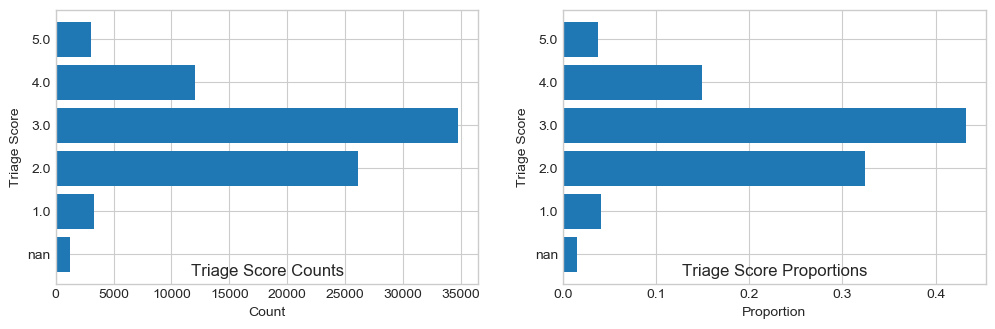

In [28]:
ctas_cd, ctas_cnt = np.unique(np.array(data['CTAS_CD'].values,dtype=str), return_counts=True)
# print(ctas_cd, ctas_cnt)
plt.subplot(2,2,1)
plt.barh(ctas_cd,ctas_cnt)
plt.title('Triage Score Counts')
plt.xlabel('Count')
plt.ylabel('Triage Score')
plt.subplot(2,2,2)
plt.barh(ctas_cd,ctas_cnt/np.sum(ctas_cnt))
plt.title('Triage Score Proportions')
plt.xlabel('Proportion')
plt.ylabel('Triage Score')
plt.show()




In [29]:
ctas_cnt/np.sum(ctas_cnt)

array([0.04104941, 0.32421953, 0.43214357, 0.1497067 , 0.03789272,
       0.01498807])

#### Notes
- The smallest proportion of complaints have a Triage score of 1, or resuscitation, which is the most severe score.
- The most common Triage score is 3 with 43% of complaints.
- Over 75% of complaints are 2 or 3 severity.

## Exercise 1
## Data Inquiries
[back to top](#Emergency-Room-Data-Analysis)

Given that a business professional is able to answer questions about the data, what questions would I ask in a follow-up meeting?



### Insights 1
The response below is mostly from the [Data Investigation](#Data-Investigation). Some points are from [Exercise 2](#Exercise-2).

1. The average count per day is 220, which could be high for the emergency room at one hospital. This would be about 9 patients per hour of day. 
    - Maybe there are repeat entries? The most entries for a single ID is 2, and there are 216 of these cases.
    - ENCOUNTER_NUM 44042 has 2 entries with different pia times: 2019-07-19T11:02:00Z vs 2019-07-19T07:02:00Z
2. The corrections seem reasonable. Trouble breathing and chest pain could be synonyms in some contexts.
3. There are double entries using the same patient ID. Fix would be to remove duplicates.
4. Negative length of stay 
    - could be the result of start and end time in wrong order. Fix could be to swap them.
5. Some ed patients have missing start time - count = 793
    - This could be due to arrival by ambulance. According to an article in The Daily Scan, "when patients first walk into the ED, they check in with the registration clerk (this step doesn’t apply to the minority of patients who arrive by ambulance)".(http://thedailyscan.providencehealthcare.org/2018/11/emergency-room-triage-how-does-it-work/)
6. Some ed patients have missing end time - count = 396
7. Some pia times are less than the ed start time - count = 15
    - since the count is small (15) relative to the number of cases (>80000), I would ask if this is an error. The fix would be to set the times from latest to earliest: ed_end, adm_start, pia.
8. Some adm start times are less than start time - count = 7
    - since the count is small (7) relative to the number of cases (>80000), I would ask if this is an error. The fix would be to set the times from latest to earliest: ed_end, adm_start, pia.
9. One patient was admitted without an adm_start_time. ENCOUNTER_NUM = 14904.
    - This seems to be a mistake. We could naively replace the time with the ed_end time minus the average time for that complaint.
10. 3 without start and end time
    - Three cases are without a start and end time.
11. 4 days are missing - April 1st, 2nd, 3rd, and 4th
    - There are 4 days without any cases.
12. The largest complaint day has 431 (July 18, 2020) and the second largest day has 279. (See Exercise 2 analysis)
    - Did something significant happen on July 18, 2020?
        - no big news https://www.toronto.com/news-story/9509709-5-at-5-toronto-news-of-the-day-for-july-18-2019/
13. The smallest complaint day has 35 complaints and is on January 1, 2020. The second smallest is 155 complaints in a day.
14. There are missing Triage Scores and Descriptions
    - count 1206
15. Length of stay of 24 hours spikes. The length of stay variable is maxed out at 24 hours.
    - we can fix this by calculating a new variable los_fix that does not max out at 24
    
    
#### List of questions to ask:
1. Is it correct to assume ed_start_time < pia_start < ed_adm < ed_end?
2. How is time data recorded? It appears that some times are missing (e.g. ed_start == NA) and inconsistent (e.g. ed_start > ed_end).
3. Do the corrections made below to presenting_complaint make sense?
4. Does the correction to length of stay fixed, los_fix make sense?
5. Is there a reason there was 431 encounters on July 18, 2020?
6. Is there a reason there was only 35 complaints on January 1, 2020?
7. How should I address missing Triage scores?
8. Is there a reason los has a max value of 24?
9. Are the corrected presenting_complaint labels below appropriate?


  



In [30]:
avg_count_per_day = 80464/365  # 220.449


#### Inquiry: there are 216 repeat encounter numbers, but only 215 duplicate rows. What happens in that one case?

In [31]:
# fix data
# remove duplicates
data_fix = data.copy(deep=True)
print(data_fix.shape)
data_fix = data_fix.drop_duplicates()
print(data_fix.shape)
data_fix.head()
print(data.duplicated().sum())
print(80464-80249)


(80464, 11)
(80249, 11)
215
215


In [32]:
np_set = set(ids_filter)
pd_set = set(data[data.duplicated()]['ENCOUNTER_NUM'].values)
print(np_set.difference(pd_set))

{44042}


In [33]:
data[data['ENCOUNTER_NUM'] == 44042]

,ENCOUNTER_NUM,CTAS_CD,CTAS_DESCR,ed_start_time,ed_end_time,ed_pia_time,adm_start_time,admitted,los,presenting_complaint,los_fix
43264,44042,2.0,EMERGENCY,2019-07-18T16:38:00Z,2019-07-19T06:02:00Z,2019-07-19T11:02:00Z,2019-07-18T21:25:00Z,1,13.4,Traumatic injury,13.4
43265,44042,2.0,EMERGENCY,2019-07-18T16:38:00Z,2019-07-19T06:02:00Z,2019-07-19T07:02:00Z,2019-07-18T21:25:00Z,1,13.4,Traumatic injury,13.4


#### Response: We can see that for the special case, the pia_time differs for both entries!

#### Investigating the different presenting_complaints

In [34]:
np.unique(data_fix['presenting_complaint'].values)

array([' Burn ', ' Confusion', 'Abdominal pain', 'Abdominal pain ',
       'Back  pain', 'Back pain', 'Bizarre behaviour', 'Burn', 'Burns',
       'Chest  pain', 'Chest pain', 'Chest pian', 'Confusion',
       'General weakness', 'Hallucinations', 'Headach', 'Headache',
       'Loss of hearing', 'Lower extremity injury', 'Missing', 'Rash',
       'Sore Throat', 'Traumatic injuries', 'Traumatic injury',
       'Trouble Breathing', 'UNK', 'Unknown', 'Upper extremity injury',
       'burns', 'rash'], dtype=object)

#### Notes
We see that some complaints are mispelled and others are synonyms. We will fix that below.

In [35]:
# correct labels
complaints = data_fix['presenting_complaint'].values
print(sorted(np.unique(complaints)))

# remove leading, trailing whitespace, and excess whitespace within
# convert all to lower case
complaints = [x.lower().strip().replace('  ',' ') for x in complaints]

# remove plural and fix spelling
# burns -> burn
# traumatic injuries -> traumatic injury
# missing -> unknown
# unk -> unknown
# burns -> burn
# chest pian -> chest pain
# headach -> headache

def fix_spelling(w):
    if w == 'burns':
        return 'burn'
    elif w == 'headach':
        return 'headache'
    elif w == 'chest pian':
        return 'chest pain'
    elif w == 'missing':
        return 'unknown'
    elif w == 'unk':
        return 'unknown'
    elif w == 'traumatic injuries':
        return 'traumatic injury'
    else:
        return w
    
complaints = [fix_spelling(w) for w in complaints]
data_fix['complaints'] = complaints





[' Burn ', ' Confusion', 'Abdominal pain', 'Abdominal pain ', 'Back  pain', 'Back pain', 'Bizarre behaviour', 'Burn', 'Burns', 'Chest  pain', 'Chest pain', 'Chest pian', 'Confusion', 'General weakness', 'Hallucinations', 'Headach', 'Headache', 'Loss of hearing', 'Lower extremity injury', 'Missing', 'Rash', 'Sore Throat', 'Traumatic injuries', 'Traumatic injury', 'Trouble Breathing', 'UNK', 'Unknown', 'Upper extremity injury', 'burns', 'rash']


#### counts and proportions of presenting complaints





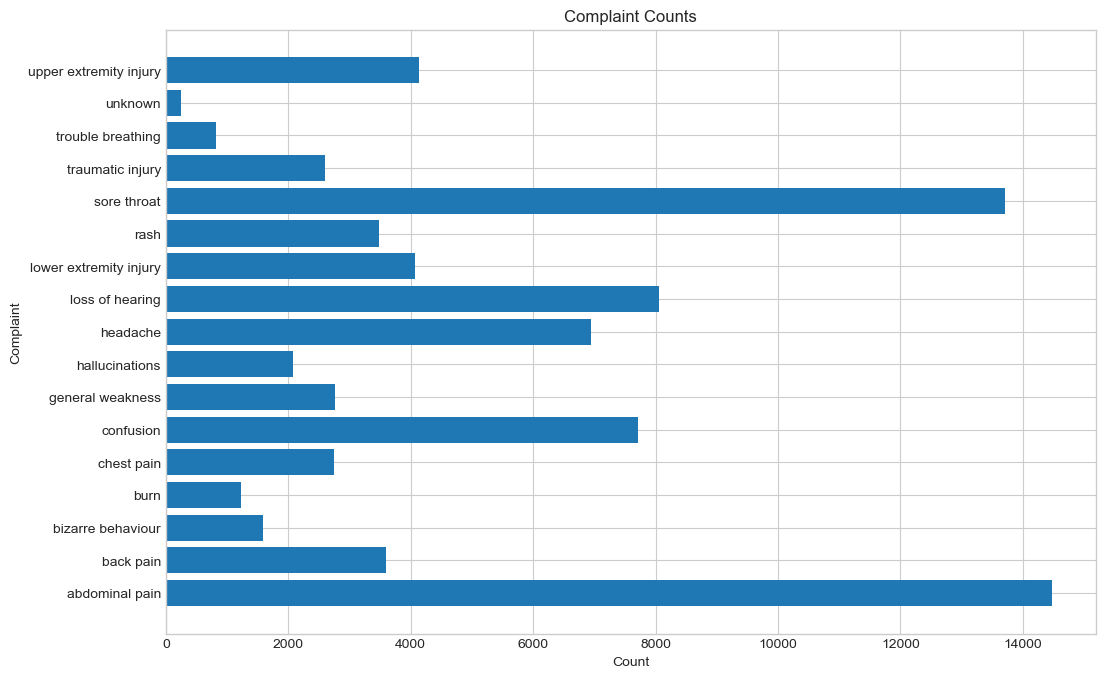

In [36]:
# counts and proportions of presenting complaints
complaint_name, complaint_count = np.unique(np.array(complaints), return_counts=True)
plt.barh(complaint_name, complaint_count)
plt.title('Complaint Counts')
plt.xlabel('Count')
plt.ylabel('Complaint')
plt.show()

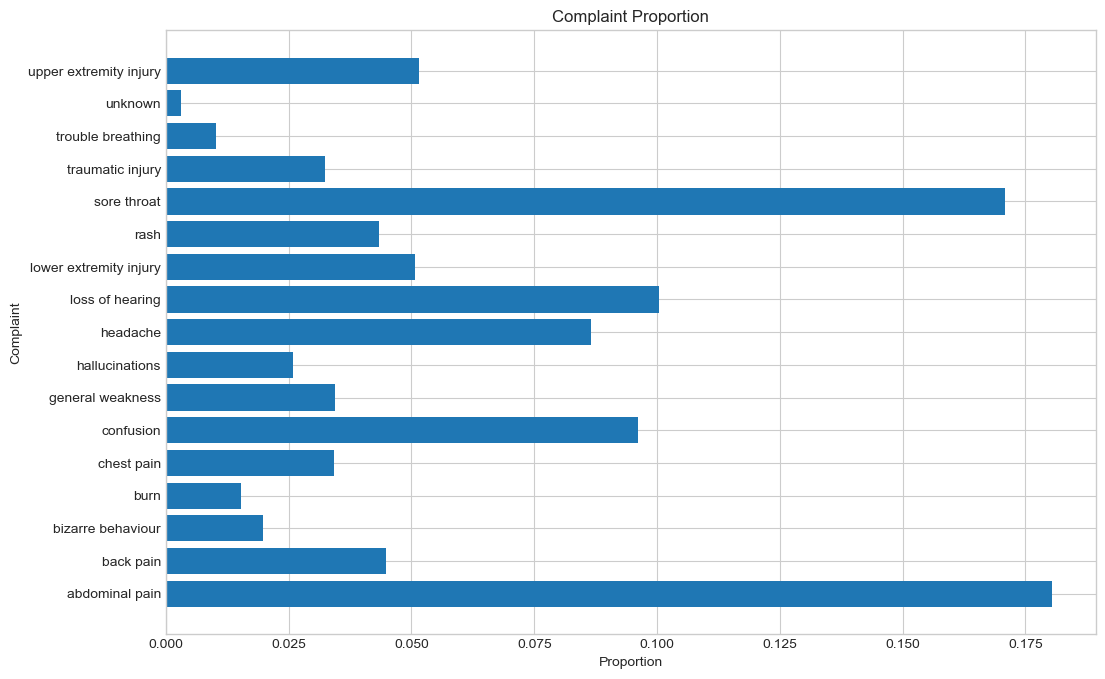

In [37]:
complaint_name, complaint_count = np.unique(np.array(complaints), return_counts=True)
plt.barh(complaint_name, complaint_count/np.sum(complaint_count))
plt.title('Complaint Proportion')
plt.xlabel('Proportion')
plt.ylabel('Complaint')
plt.show()

Notes:
- abdominal pain and sore throat are the most common
- trouble breathing and burn are the least common

In [38]:
# how to fix the no start time value - can only guess, so we'll need to ask if they want approximations
# fix the no end time value - can only approximate using other cases with the same issue

# fix start > end - swap the values
# fix pia > start - swap the values
# isolate the 3 columns, do comparisons, replace columns in the data
ed_start = data_fix['ed_start_time'].values
ed_end = data_fix['ed_end_time'].values
ed_pia = data_fix['ed_pia_time'].values
adm_start = data_fix['adm_start_time'].values

# how many start, end, pia, and adm start are wrong

## Encounters Per Day Analysis
[back to top](#Emergency-Room-Data-Analysis)
<br>
The main analysis requires us to look at the number of encounters per day. 

1. What is the average number of arrivals to the emergency department per day? 
2. Are there any data quality issues I am concerned with? 









#### Extract complaint dates
- check emergency department start time. If missing, check ed end time. If missing, check pia time. If missing, check adm start time. If missing, complaint date is NA. 

In [39]:
# create column for date and aggregate counts based on day
def get_date(t):
    return datetime.datetime.strptime(t[:10], "%Y-%m-%d").date()

dates_1 = [str(get_date(t)) if not pd.isnull(t) else t for t in ed_start]
dates_2 = [str(get_date(t)) if not pd.isnull(t) else t for t in ed_end]
dates_3 = [str(get_date(t)) if not pd.isnull(t) else t for t in ed_pia]
dates_4 = [str(get_date(t)) if not pd.isnull(t) else t for t in adm_start]

def find_date(idx):
    # check idx across dates_1, _2, _3, _4
    if not pd.isnull(dates_1[idx]):
        return dates_1[idx]
    elif not pd.isnull(dates_2[idx]):
        return dates_2[idx]
    elif not pd.isnull(dates_3[idx]):
        return dates_3[idx]
    else:
        return dates_4[idx]

# use ed start date or ed end date if start date is missing

#dates = [dates_1[i] if not pd.isnull(dates_1[i]) else dates_2[i] for i in range(len(ed_start))]
dates = [find_date(idx) for idx in range(len(ed_start))]

x_day, y_count = np.unique(dates, return_counts=True)
# last element is na's
print(x_day[-1], 'count:', y_count[-1])



# x-axis = day, y-axis = count => no NAN dates


2020-01-01 count: 35


In [40]:
print(len(x_day))

362


### Plot Complaint Count vs Day

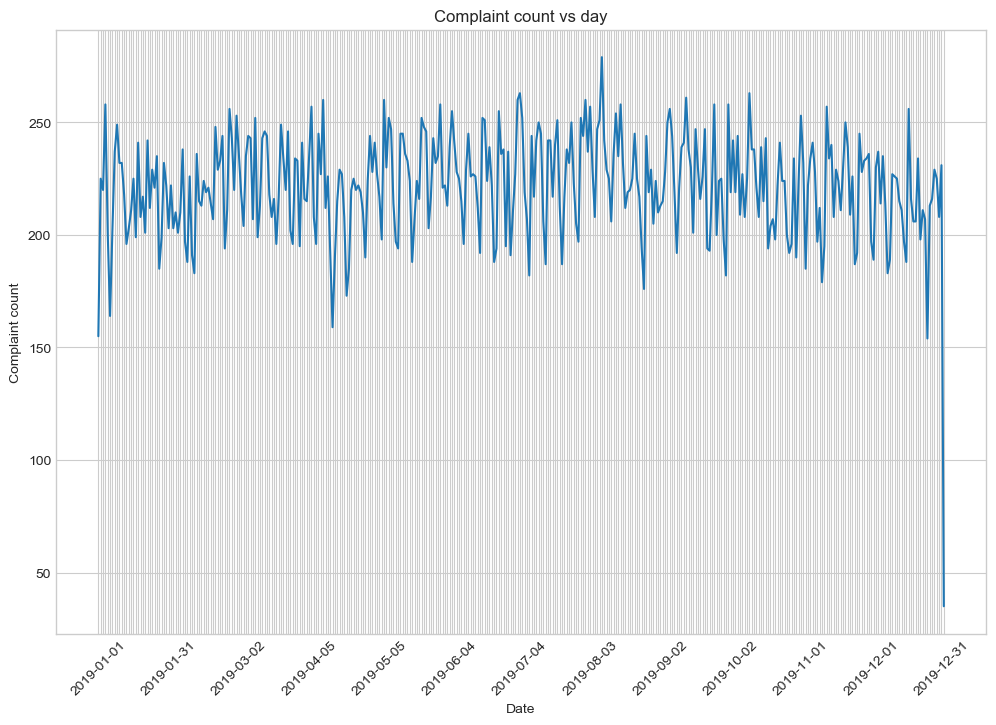

In [41]:
x_data = x_day
y_data = y_count

fig, ax = plt.subplots()

plt.plot(x_data,y_data)
plt.xticks(rotation=45)

every_nth = 30
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)


plt.title("Complaint count vs day")
plt.xlabel('Date')
plt.ylabel('Complaint count')
plt.show()

#### Notes:
- huge spike on July 18, 2019
- huge dip on January 1, 2020

In [42]:
# largest complaint count investigation
print('day with highest complaints:',x_data[np.argmax(y_data)])
print('highest single day complaint count:',max(y_data))
print('day with second highest complaints:',np.sort(y_data)[-2])

# smallest complaint count investigation
print('day with lowest complaints:',x_data[np.argmin(y_data)])
print('lowest single day complaint count:',min(y_data))
print('day with second lowest complaints:',np.sort(y_data)[2])

day with highest complaints: 2019-08-08
highest single day complaint count: 279
day with second highest complaints: 263
day with lowest complaints: 2020-01-01
lowest single day complaint count: 35
day with second lowest complaints: 155


In [43]:
avg = np.mean(y_data)
med = np.median(y_data)
print('mean complaint count per day:',np.mean(y_data))
print('median complaint count per day:',np.median(y_data))
# max and max day
max_val = np.max(y_data)
min_val = np.min(y_data)
print('max complaint count:', np.max(y_data), 'on day:',x_data[np.argmax(y_data)])
print('min complaint count:', np.min(y_data), 'on day:',x_data[np.argmin(y_data)])
std = np.std(y_data,ddof=1)
print('standard deviation of cases:', np.std(y_data,ddof=1))  # unbiased std
print('max std from mean:',(max_val-avg)/std)
print('min std from mean:',np.absolute(min_val-avg)/std)



mean complaint count per day: 221.68232044198896
median complaint count per day: 224.0
max complaint count: 279 on day: 2019-08-08
min complaint count: 35 on day: 2020-01-01
standard deviation of cases: 23.416881169073438
max std from mean: 2.447707666284365
min std from mean: 7.97212571111047


In [44]:

print(len(x_day))  # number of days
# what days are missing?
# check by month
def print_ifin_month(data,m):
    # m must be a 2 digit string
    count = 0
    for d in data:
        if d[5:7] == m:
            count += 1
            #print(d)
    print(count)

print_ifin_month(x_day,'04') 
## jan has extra for 2020-01-01, feb is good, April only has 26, missing April 1 to 4
## all other months are good for counts
# 361 w/o nan and jan 1 2020, so 4 days missing for april 1 to 4

362
26


### Insights 2
The average number of complaints per day is 222 and the median number of complaints is 224. The max number of complaints in 431 on July 18, 2019. The min number of complaints is 35 on January 1, 2020.

The max complaint count is over 8 standard deviations from the mean, and the min complaint count is over 7 standard deviations from the mean. The data for days April 1 to 4 are missing. Are the max and min day counts correct because they seem to be quite far from the average/median complaint counts?



## Volume Analysis
[back to top](#Emergency-Room-Data-Analysis)
<br>
Look at the average and standard deviation of volumes on weekends and weekdays. Make two side by side histograms displaying the distribution of arrivals on weekends and weekdays. Make a boxplot of encounters per day by weekday vs weekend. Is there a difference in the arrivals? Which plot is best for showing the difference?







In [45]:
def get_day_week_simple(t):
    # Monday is 0 and Sunday is 6
    return datetime.datetime.strptime(t, "%Y-%m-%d").weekday()

x_dow = [get_day_week_simple(d) for d in dates]
day_lab, day_count = np.unique(x_dow, return_counts=True)

In [46]:
weekday_x = day_lab[:5]
weekend_x = day_lab[5:]
weekday_y = day_count[:5]
weekend_y = day_count[5:]

In [47]:
# we have counts/day
# need to map it to counts/day for weekend vs counts/day for weekday
x_weekday_counts = [y_count[i] for i in range(len(y_count)) if get_day_week_simple(x_day[i]) < 5]
x_weekend_counts = [y_count[i] for i in range(len(y_count)) if get_day_week_simple(x_day[i]) >= 5]

print('average weekday day:', np.mean(x_weekday_counts))
print('std weekday day:',np.std(x_weekday_counts,ddof=1))
print('average weekend day:', np.mean(x_weekend_counts))
print('std weekend day:', np.std(x_weekend_counts,ddof=1))

average weekday day: 224.16666666666666
std weekday day: 24.5882697455335
average weekend day: 215.51923076923077
std weekend day: 18.961883467769166


#### Distributions of counts by day of the week

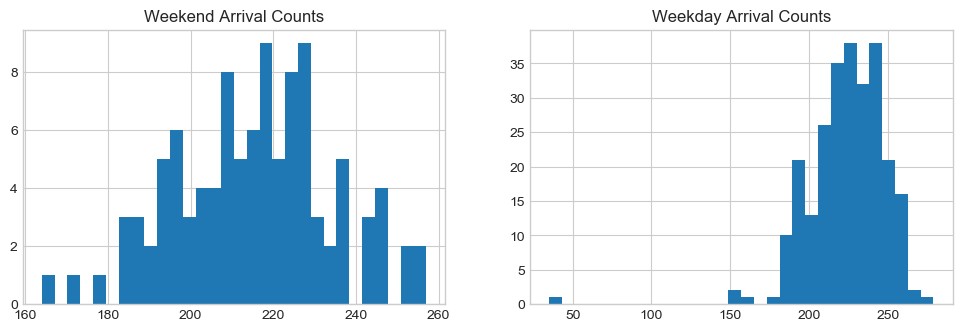

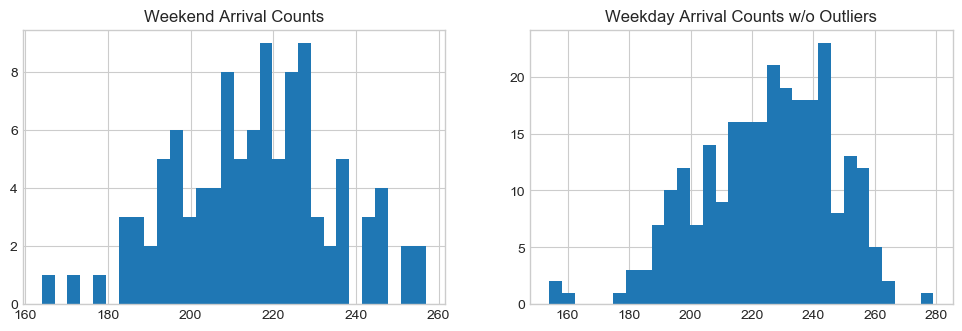

In [48]:
# weekday_x = [d for d in x_dow if d<5]
# weekend_x = [d for d in x_dow if d>=5]

plt.figure(3)
plt.subplot(2,2,2)
plt.hist(x_weekday_counts,bins=30)
plt.title('Weekday Arrival Counts')
# plt.xticks([0.2,1,2,3,3.8], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], rotation=20)  # to centre labels
# plt.show()
# plt.figure(4)
plt.subplot(2,2,1)
plt.hist(x_weekend_counts,bins=30)
# plt.xticks([5.2,5.7], ['Saturday', 'Sunday'], rotation=20)
plt.title('Weekend Arrival Counts')
plt.show()

# hard to tell so remove outliers in weekday counts
weekday_x_new = [c for c in x_weekday_counts if c>100 and c<350]

plt.figure(4)
plt.subplot(2,2,2)
plt.hist(weekday_x_new,bins=30)
plt.title('Weekday Arrival Counts w/o Outliers')
# plt.xticks([0.2,1,2,3,3.8], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], rotation=20)  # to centre labels
# plt.show()
# plt.figure(4)
plt.subplot(2,2,1)
plt.hist(x_weekend_counts,bins=30)
# plt.xticks([5.2,5.7], ['Saturday', 'Sunday'], rotation=20)
plt.title('Weekend Arrival Counts')
plt.show()

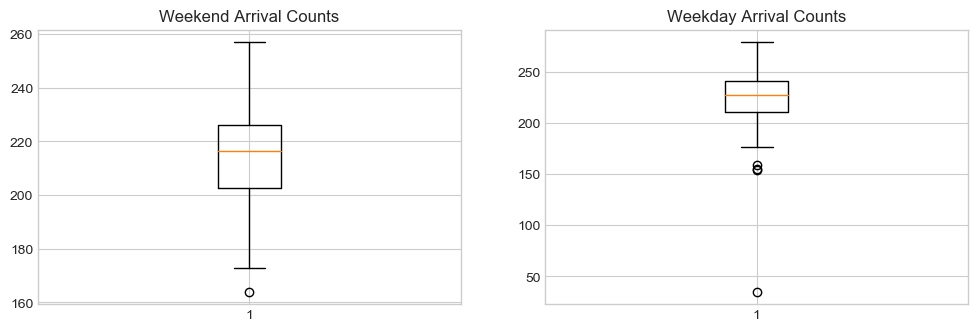

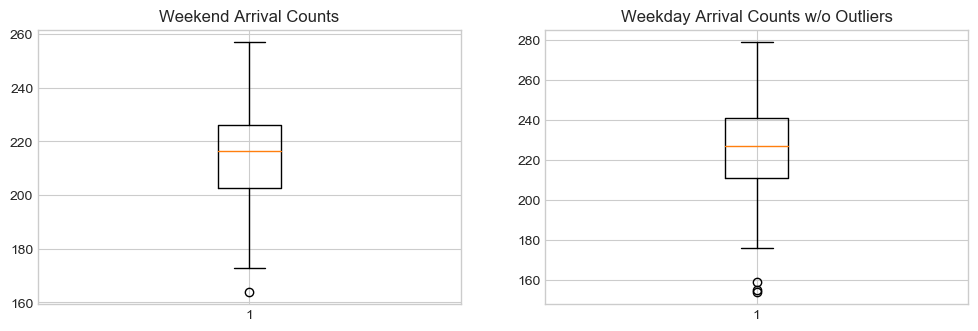

In [49]:
# plot box plots
plt.figure(4)
plt.subplot(2,2,2)
plt.boxplot(x_weekday_counts)
plt.title('Weekday Arrival Counts')
plt.subplot(2,2,1)
plt.boxplot(x_weekend_counts)
plt.title('Weekend Arrival Counts')
plt.show()
# try without outliers
plt.figure(5)
plt.subplot(2,2,2)
plt.boxplot(weekday_x_new)
plt.title('Weekday Arrival Counts w/o Outliers')
plt.subplot(2,2,1)
plt.boxplot(x_weekend_counts)
plt.title('Weekend Arrival Counts')
plt.show()


### Insights 3
It appears that there is a difference in arrivals; however, it is not certain whether the difference is statistically significant. In both the histogram and the boxplot, it was hard to see the difference in arrivals without removing the outliers from the weekday counts. After removing the outliers, both the histogram and the boxplot show a difference, where the weekday arrival count was greater than the weekend arrival count. If one plot must be deemed better than the other, the boxplot would be better since it clearly shows the quantiles associated with the data.

## Hypothesis Test
[back to top](#Emergency-Room-Data-Analysis)
<br>
The classic way to determine if the difference you calculated above is “real” is to conduct a hypothesis test. We conduct a two-sample t-test below. 





In [50]:

scipy.stats.ttest_ind(x_weekend_counts, x_weekday_counts, equal_var=False)

Ttest_indResult(statistic=-3.590471060148938, pvalue=0.00039874393261581933)

### Insights 4




Since pvalue < 0.05, we reject the null hypothesis and say the difference in arrival time is statistically significant.

In [51]:
# check why values are different than above
# x_weekday_counts
# x_weekend_counts
x1_bar = np.mean(x_weekend_counts)
x2_bar = np.mean(x_weekday_counts)
s1 = np.std(x_weekend_counts, ddof=1)
s2 = np.std(x_weekday_counts, ddof=1)
n1 = len(x_weekend_counts)
n2 = len(x_weekday_counts)
std = (s1**2/n1+s2**2/n2)**0.5
t_stat = (x1_bar-x2_bar)/(s1**2/n1+s2**2/n2)**0.5
est = x1_bar-x2_bar
df = (s1**2/n1+s2**2/n2)**2/(s1**4/(n1**2*(n1-1))+s2**4/(n2**2*(n2-1)))
print('estimate:',est)
print('estimate 1:',x1_bar)
print('estimate 2:',x2_bar)
print('test statistic:',t_stat)
print('degrees of freedom:',int(df))
conf = scipy.stats.t.interval(0.95,int(df))
print('confidence interval:',(conf[0]*std+est, conf[1]*std+est))




estimate: -8.647435897435884
estimate 1: 215.51923076923077
estimate 2: 224.16666666666666
test statistic: -3.590471060148938
degrees of freedom: 244
confidence interval: (-13.391423008826763, -3.9034487860450042)


## Permutation Distribution Analysis
[back to top](#Emergency-Room-Data-Analysis)
<br>

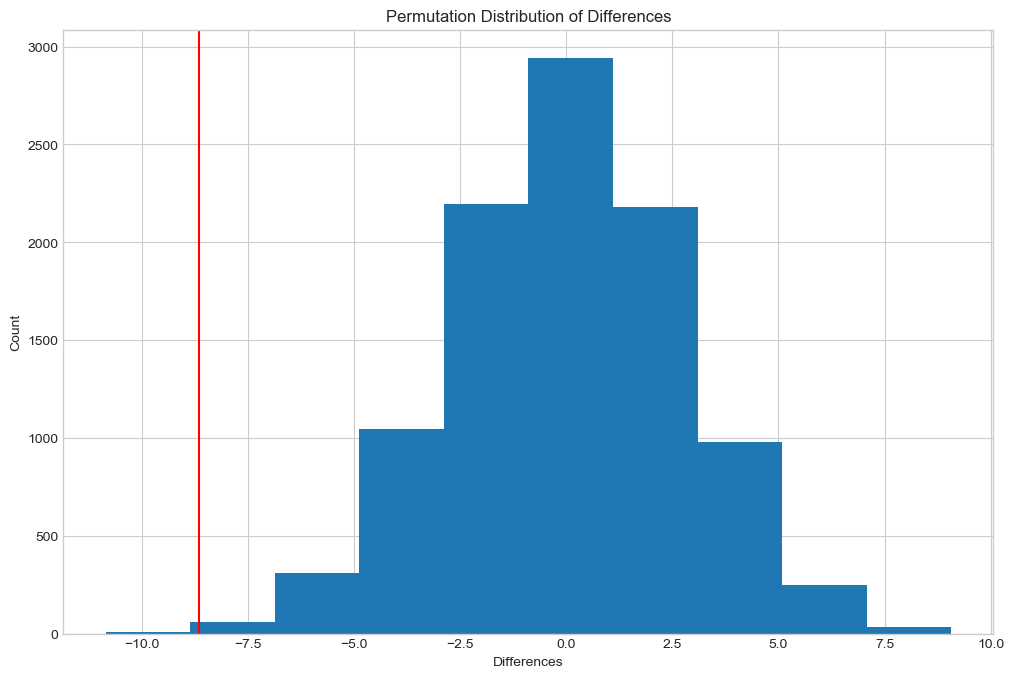

In [52]:
# randomly permute all 362 day counts
import sklearn.model_selection
np.random.seed(23)
# print('number of weekdays:',len(x_weekday_counts))  # 258
# print('number of weekends:',len(x_weekend_counts))  # 104
counts_data = y_count
weekends, weekdays = sklearn.model_selection.train_test_split(y_count, train_size=104)

def run_experiment(data, iterations=10000, split=104):
    diffs = list()
    for i in range(iterations):
        weekends, weekdays = sklearn.model_selection.train_test_split(data, train_size=split)
        diffs.append(np.mean(weekends)-np.mean(weekdays))
    return diffs

diffs = run_experiment(y_count)
plt.hist(diffs)
plt.axvline(x=est, c='red')
plt.title('Permutation Distribution of Differences')
plt.xlabel('Differences')
plt.ylabel('Count')
plt.show()

In [53]:
# our test is the proportion of observations that have a difference in mean greater than the observed difference
abs_diffs = np.absolute(diffs)
perm_t_stat = np.absolute(est)
perm_p_val = np.sum(abs_diffs >= perm_t_stat)/len(abs_diffs)
print('permutation distribution test statistic:',perm_t_stat)
print('permutation distribution p-value:',perm_p_val)


permutation distribution test statistic: 8.647435897435884
permutation distribution p-value: 0.001


### Insights 5
The permutation distribution can be seen in the above histogram, where the red vertical line is the difference with the original labels. We use the sample distribution of the differences as an approximation for the actual distribution of differences. Thus, we can perform a hypothesis test on the original difference using the permutation distribution as our reference distribution. We can use the proportion of absolute differences greater than or equal to the absolute original difference as our p-value, which is 0.0009. Using the permutation distribution, we have enough information to reject the null hypothesis that there is no difference between weekend and weekday arrival counts. As a result, we conclude that there is a difference in arrival counts on weekends versus weekdays. 

## Census Analysis
[back to top](#Emergency-Room-Data-Analysis)
<br>
Which hour has the highest average census?

We can use this information to align clinician working hours to when there is the highest number of patients in the emergency department. The census, defined as the number of patients in the ED at any given time, is usually a more important metric than arrivals since new arrivals simply add on to patients already in ED. 





In [54]:


# get (arrival, departure) times
start_data = ed_start
end_data = ed_end
# check_1 = start_data > end_data
# start_data_fix =  # remove all NAs and times when start > end
# end_data_fix = # remove all NAs and times when start > end

def fix_datasets(start, end):
    start_fix = list()
    end_fix = list()
    n = len(start)
    for i in range(n):
        if pd.isnull(start[i]) or pd.isnull(end[i]):
            continue
        start_time = datetime.datetime.strptime(start[i], "%Y-%m-%dT%H:%M:%SZ")
        end_time = datetime.datetime.strptime(end[i], "%Y-%m-%dT%H:%M:%SZ")
        if start_time <= end_time:
            start_fix.append(start_time)
            end_fix.append(end_time)

    return start_fix, end_fix

def round_minutes(times):
    #  2019-01-01T06:11:00Z
    def round_min(t):
        # make seconds 00
        return t.replace(minute=0,second=0)
    return [round_min(t) for t in times]


start_data_fix, end_data_fix = fix_datasets(start_data, end_data)
start_data_fix = round_minutes(start_data_fix)
end_data_fix = round_minutes(end_data_fix)
        


In [55]:
# Notes:
# before making a function, let's find the ed volume at a particular time
# we will aggregate data based on minute (smallest time considered)
# we need 2 datasets (1 for arrivals, 1 for departures)
# before creating the dataset, only use datapoints that have ed_start_time and ed_end_time values
# split into 2 datasets (1 with (arrival time, +1), and the other with (departure time, -1))
# given a particular time, we need to know how many people are already in the ed - function for this
# we can use this as our initial counter
# if we group data based on minute or hour, we will have gaps in the data, so we will need to fill the gaps
# and keep track of the running sum


start_time = datetime.datetime.strptime('2019-01-01T00:00:00Z', "%Y-%m-%dT%H:%M:%SZ")

# find set of people who started before and ended after
df = pd.DataFrame({'start':start_data_fix, 'end':end_data_fix})

print(df.dtypes)
pre = df[(df.start < start_time) & (df.end >= start_time)]

post = df[df.end > start_time]

arrivals = df[df.start >= start_time]
arrivals['counter'] = np.array([1]*arrivals.shape[0])
arrivals = arrivals.drop('end', axis=1)
arrivals.columns = ['time', 'counter']

departures = post.copy()
departures['counter'] = np.array([-1]*departures.shape[0])
departures = departures.drop('start', axis=1)
departures.columns = ['time', 'counter']

census_volumes = pd.concat([arrivals, departures],axis=0)

# create df to join with 
times_data = [start_time + datetime.timedelta(hours=i) for i in range(366*24)]
times_df = pd.DataFrame({'time':times_data})



census_volumes.iloc[0,1] += pre.shape[0]
census_volumes = census_volumes.groupby(['time']).sum().reset_index()
print(census_volumes.head())

census_volumes = pd.merge(times_df,census_volumes,on='time',how='left').fillna(value=0)
print(census_volumes.head(10))

census_volumes['cumsum'] = census_volumes['counter'].cumsum()

census_volumes = census_volumes.reset_index(drop=True)
print(census_volumes.head())


start    datetime64[ns]
end      datetime64[ns]
dtype: object
                 time  counter
0 2019-01-01 06:00:00        8
1 2019-01-01 07:00:00       12
2 2019-01-01 08:00:00        5
3 2019-01-01 09:00:00        3
4 2019-01-01 10:00:00        3
                 time  counter
0 2019-01-01 00:00:00      0.0
1 2019-01-01 01:00:00      0.0
2 2019-01-01 02:00:00      0.0
3 2019-01-01 03:00:00      0.0
4 2019-01-01 04:00:00      0.0
5 2019-01-01 05:00:00      0.0
6 2019-01-01 06:00:00      8.0
7 2019-01-01 07:00:00     12.0
8 2019-01-01 08:00:00      5.0
9 2019-01-01 09:00:00      3.0
                 time  counter  cumsum
0 2019-01-01 00:00:00      0.0     0.0
1 2019-01-01 01:00:00      0.0     0.0
2 2019-01-01 02:00:00      0.0     0.0
3 2019-01-01 03:00:00      0.0     0.0
4 2019-01-01 04:00:00      0.0     0.0


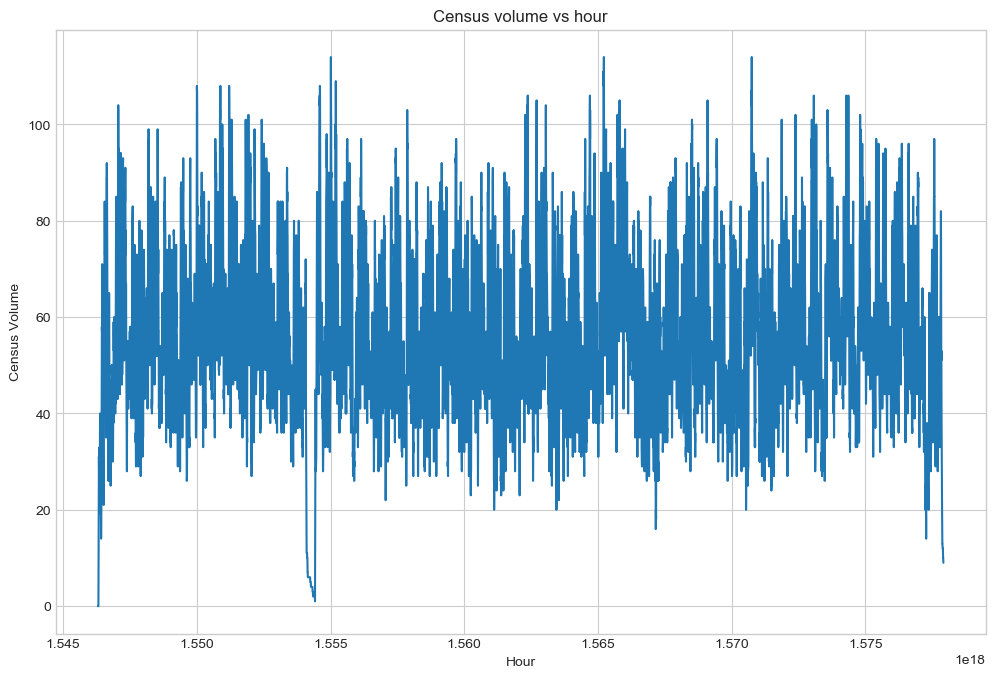

In [56]:
plt.plot(census_volumes['time'].values, census_volumes['cumsum'].values)
plt.title('Census volume vs hour')
plt.xlabel('Hour')
plt.ylabel('Census Volume')
plt.show()

In [57]:
# which hour of the day has the highest census count?
# map each time to the hour
hour_data = [str(t)[11:13] for t in census_volumes['time'].values]
hour_df = pd.DataFrame({'hour':hour_data, 'cumsum':census_volumes['cumsum'].values}).groupby('hour').mean().reset_index()

In [58]:
print(hour_df.columns)
print(hour_df.head)

Index(['hour', 'cumsum'], dtype='object')
<bound method NDFrame.head of    hour     cumsum
0    00  68.702186
1    01  67.461749
2    02  66.543716
3    03  64.278689
4    04  61.196721
5    05  57.163934
6    06  51.893443
7    07  47.352459
8    08  44.896175
9    09  43.666667
10   10  42.390710
11   11  40.650273
12   12  39.084699
13   13  39.612022
14   14  41.642077
15   15  46.300546
16   16  53.557377
17   17  60.368852
18   18  65.497268
19   19  69.437158
20   20  71.404372
21   21  72.204918
22   22  72.095628
23   23  70.603825>


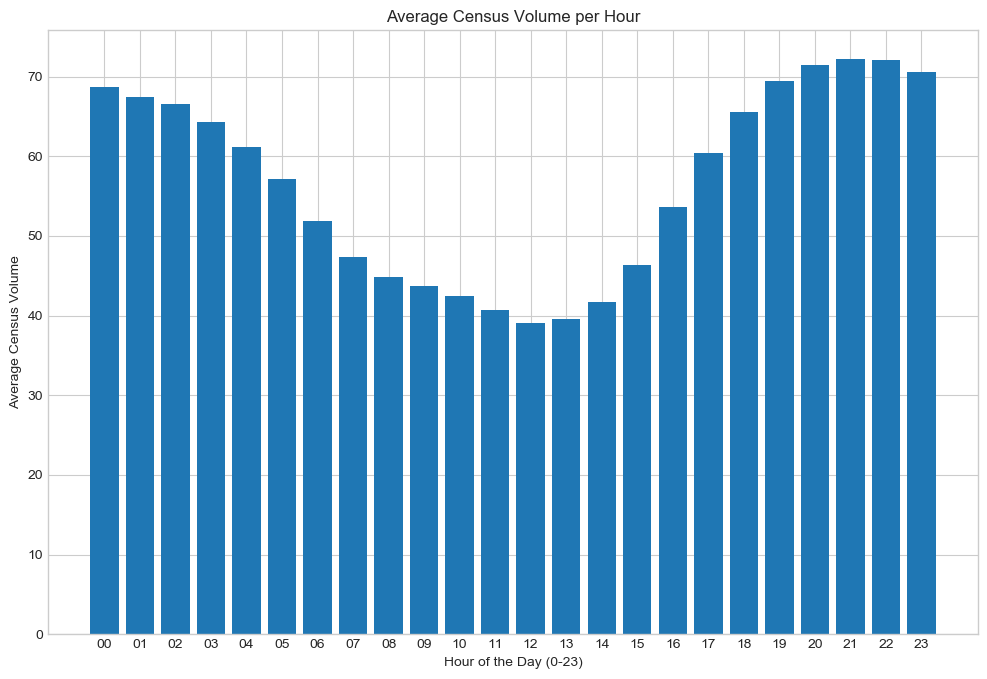

In [59]:
plt.bar(hour_df['hour'], hour_df['cumsum'])
plt.title('Average Census Volume per Hour')
plt.xlabel('Hour of the Day (0-23)')
plt.ylabel('Average Census Volume')
plt.show()

In [60]:
print(hour_df[hour_df['cumsum'] == hour_df['cumsum'].max()])

# could try some sort of clustering?

   hour     cumsum
21   21  72.204918


### Insights 6
The hour with the highest average census is 21:00 or 9:00 PM, with an average census of 72 people.

### Key Takeaways
[back to top](#Emergency-Room-Data-Analysis)

#### Data Quality:
For the most part, the data quality seems good. The main concerns are that there are missing dates, times, and triage scores. About 2% of the complaints have time data that needs to be justified or corrected. See [Insights 1](#Insights-1) for a full list of concerns.

#### Questions to clarify:
Please see [questions to ask](#List-of-questions-to-ask:).

#### Descriptive Statistics:
From looking at the distribution of [Length of stay](#Length-of-stay), we can see that the majority of patients stay less than 5 hours. From looking at the distribution of [Time to seeing a physician](#Time-to-seeing-a-physician), we note that most see a physician within 3 hours of arrival at the emergency department. When investigating the distribution of [presenting complaints](#counts-and-proportions-of-presenting-complaints), we know that the most common complaints are abdominal pain and sore throat, and trouble breathing and burn are the least common. When considering the distribution of [counts and proportinos of triage scores](#counts-and-proportions-of-Triage-scores), we see the smallest proportion of complaints have a Triage score of 1, or resuscitation, which is the most severe score; the most common Triage score is 3 with 43% of complaints; over 75% of complaints are 2 or 3 severity. Furthermore, the distribution of number of encounters seen per day on a [day-of-the-week basis](#Distributions-of-counts-by-day-of-the-week) shows that while numbers are pretty consistent for each day, there are fewer cases on weekends, and the two fewest case days are Sunday and Monday.

#### Key questions:
1. **Are more encounters seen on weekdays than on weekends?** <br>
    More cases are seen on weekdays than weekends. See [Volume Analysis](#Volume-Analysis) for the visual representation. See [Hypothesis Testing](#Hypothesis-Test) for a standard statistical test that supports the result. See [Permutation Distribution Analysis](#Permutation-Distribution-Analysis) for an intuitive statistical test supporting the result.
2. **At which hour of the day do we see the most encounters?** <br>
    The hour of the day with the most encounters, 72 complaints on average, is hour 21:00 or 9:00 PM; however, the time frame from hour 20:00 to 23:00 has on average above 70 complaints so that is the busiest window of time. See [Census Analysis](#Census-Analysis) for details. 



